# GemPy Workshop: Geophysics and Probability
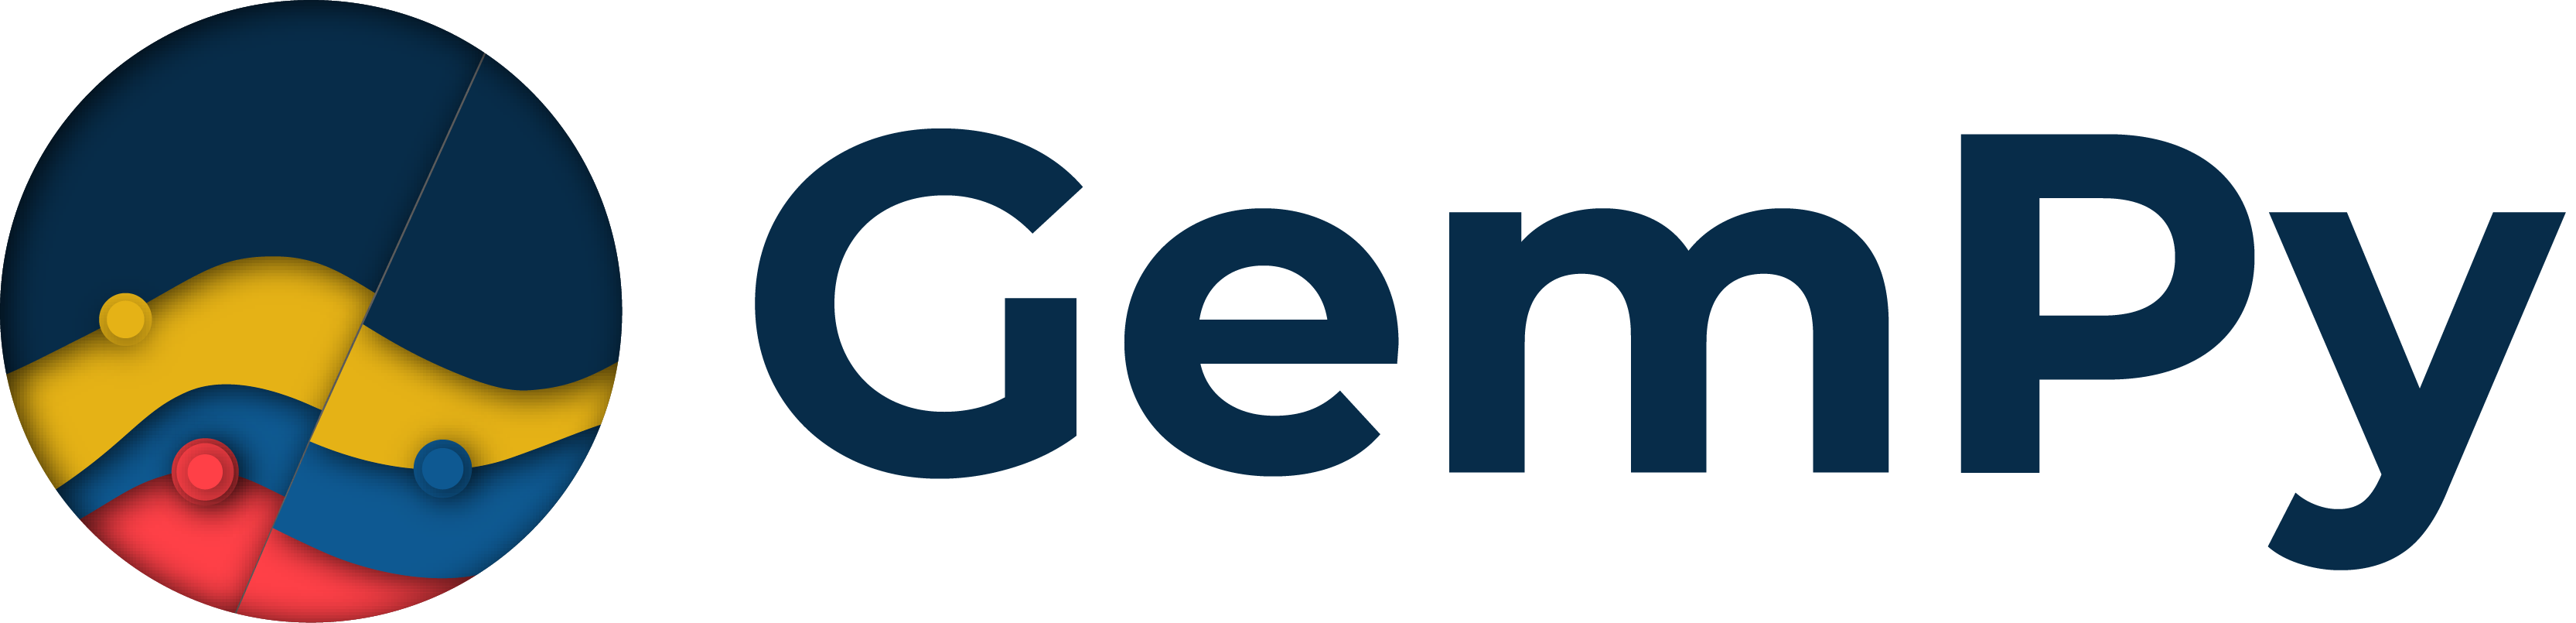


In [ ]:
# List of relative paths used during the workshop
path_to_checkpoint_3 = 'checkpoints/checkpoint3.pickle'


In [ ]:
import warnings
warnings.filterwarnings("ignore")


# Importing auxiliary libraries
import matplotlib
import os
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda,floatX=float32"

import theano
theano.config.cast_policy = "numpy+floatX"

 
import pymc3 as pm
import arviz as az


# Importing GemPy
import gempy as gp

# Importing aux libraries
from ipywidgets import interact
import numpy as np
import matplotlib.image as mpimg

# Embedding matplotlib figures in the notebooks
%matplotlib qt5

In [ ]:
geo_model = gp.load_model_pickle(path_to_checkpoint_3)

# Default plotting setting
p2d = gp.plot_2d(geo_model)
ax = p2d.axes[0]
# Reading image
p3d = gp.plot_3d(geo_model, plotter_type='background', show_topography=True)


### Forward gravity

GemPy also allows for inversions. We can see a small demo how this works.

The first thing to do is to assign densities to each of the units:

In [ ]:
geo_model.add_surface_values([0, 2.6, 2.4, 3.2, 3.6], ['density'])

Also we can create a centered grid around a device for precision:

In [ ]:
geo_model.set_centered_grid(centers= [[400, 0, 0]], 
                            resolution = [10, 10, 100],
                            radius=800)

In [ ]:
from aux_func import plot_centered_grid
p = plot_centered_grid(geo_model.grid.centered_grid)

We need to modify the graph to add the branch of algebra necessary to compute
 gravity from prisms. This also means that we need to recompile the `theano`
 function:

In [ ]:
geo_model.update_to_interpolator()

In [ ]:
geo_model.modify_options("dtype", "float32")

In [ ]:
gp.set_interpolator(geo_model,
                    output=['gravity'],
                    dtype = "float32",
                    theano_optimizer='fast_run')

But now additionally to the interpolation we also compute the forward gravity of
 the model (at the point XYZ = 400, 0, 0)

In [ ]:
gp.compute_model(geo_model)
geo_model.solutions.fw_gravity

We can visualize it it better in the following figure. The aim of an inversion is to find the set of parameters that 
fit a measured point the better. In this example the red x symbolize the measured gravity while  the blue dots are 
the current gravity (and previous) fw gravity values.  The widget moves up and down the surface 3

In [ ]:
from aux_func import plot_grav_inter
grav_invert = plot_grav_inter(geo_model)

In [ ]:
interact(grav_invert, dz=(-200, 200, 10))

-----------

<div class="alert alert-block alert-info"><b>Checkpoint:</b> Next cell will load the
model from disk to the necessary state to continue.</div>

___________

## Probabilistic Modeling

When dealing with geological data, uncertainty is always present. Device precision
and error, interpretations or extrapolations, the sources of uncertainty are
many and very heterogeneous. Probabilistic modeling enable to capture some
of this epistemic uncertainty - i.e. lack of knowledge - into **aleatoric** uncertainty
that we can represent by probability distributions.

In this tutorial be will introduce some basic concepts and building blocks and
how all can be coupled with `gempy`.

Let's construct a very simple probabilistic model. We will have only 3 random
variables that define the depth of each of the surfaces.

First we need to see which surface points we want to modify:

In [ ]:
geo_model.surface_points

In [ ]:
indices_bool = geo_model.surface_points.df['surface'].isin(['surface1', 'surface2', 'surface3'])
indices = geo_model.surface_points.df.index[indices_bool]
indices

Indices from 0 to 7 are defining the layers of interest.

When we define a normal variable we can either doing it by define its absolute
position or its variance centering the mean at 0 - for normal distributions the result is the same.
For this tutorial I would use the second for convenience.

In [ ]:
# First we need to store the initial depth location
Z_init = geo_model.surface_points.df.loc[indices, 'Z'].copy()
Z_init


We can sample the variance of those values and added it to the initial values:

In [ ]:
# Defining the variance for each layer
Z_var = np.random.normal(0, # Mean certered on 0
                     30, # Variance of the location
                     size=3 # Number of random variables
                     )

Z_loc = np.hstack([Z_init[[1,2,0]] + Z_var[0],
                   Z_init[[3, 4]] + Z_var[1],
                   Z_init[[5, 6, 7]] + Z_var[2]])

Z_loc

And now we can modify the location of `gempy` surface points:

In [ ]:
p3d = gp.plot_3d(geo_model, plotter_type="background")
p3d.toggle_live_updating()

In [ ]:
# We are going to be extra verbose here!

geo_model.modify_surface_points(indices,
                                Z=Z_loc,
                                plot_object=p3d)

Once we have the code to sample from the probability space we can make a function out of it...

In [ ]:
# We can create a function
def sample(silent=True):
    # Defining the variance for each layer
    Z_var = np.random.normal(0, # Mean certered on 0
                         30, # Variance of the location
                         size=3 # Number of random variables
                         )

    Z_loc = np.hstack([Z_init[[1,2,0]] + Z_var[0],
                   Z_init[[3, 4]] + Z_var[1],
                   Z_init[[5, 6, 7]] + Z_var[2]])

    if silent is True:
        geo_model.modify_surface_points(indices, Z=Z_loc)
        gp.compute_model(geo_model)
    else:
        geo_model.modify_surface_points(indices, Z=Z_loc, plot_object=p3d)

    # Returns the 3d lith array
    return geo_model.solutions.lith_block

...and now we can call it as often as we want.

In [ ]:
sample(silent=False)


By appliying simple Monte Carlo Error propagation we can integrate the unceratinty of the input data with a simple loop:

In [ ]:
lith_blocks = np.array([])
n_iterations = 100
for i in range(n_iterations):
    lith_blocks = np.append(lith_blocks, sample())

In [ ]:
# Now we have in memory 50 different geological modeling
lith_blocks = lith_blocks.reshape(n_iterations, -1)
lith_blocks.shape

Visualizing uncertainty and probability in 3D can be challenging. `gempy` comes with some functionality to help with that. The first possibility is to visualize the probability of a occurrence of a given layer:

In [ ]:
from gempy.bayesian.fields import compute_prob, calculate_ie_masked
prob_block = compute_prob(lith_blocks[:2000])

In [ ]:
layer = 2
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prob_block[layer],
                  kwargs_regular_grid={'cmap': 'viridis',
                                        'norm': None}
                  )


To visualize multiple layers, information entropy encapsulate several probability fields in one single metric. This give a general idea of the **uncertain** areas of your domain:

In [ ]:
entropy_block = calculate_ie_masked(prob_block)
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=entropy_block,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None}
                  )



## Intro to Bayesian Inference using pymc3

Until now we have seen how we can propagate uncertainty from the input parameters to hte full 3D model space. Altough in many occassions this may be useful in itself, as the number of stochastic parameters increase it is relatively difficult to keep geological realism in place.

Bayesian inference will allow us not only to have probabilistic models but also to **learn** which of the possible realizations better describe **additional information**.

In this chapter we will see how by combining the forward gravity computation with probabilisitc modeling, we can generate an assamble of models that honor - in this case, the gravity - observation.


<div class="alert alert-block alert-info"><b>Checkpoint:</b> Next cell will load the
model from disk to the necessary state to continue.</div>

In [ ]:

%matplotlib inline
# geo_model = gp.load_model_pickle('checkpoint3.pickle')
indices_bool = geo_model.surface_points.df['surface'].isin(['surface1', 'surface2', 'surface3'])
indices = geo_model.surface_points.df.index[indices_bool]
Z_init = geo_model.surface_points.df.loc[indices, 'Z'].copy()


### Replicating the previous example in pymc3

The first step is going to replicate the previous exercise now in `pymc3`. `pymc3` relay on `theano` for automatic differentiation which enable state-of-the-art samplers.

In [ ]:
import theano.tensor as tt

def sample_grav(Z_var2):
    Z_loc = np.hstack([Z_init[[1,2,0]] + Z_var2[0],
                       Z_init[[3, 4]] + Z_var2[1],
                       Z_init[[5, 6, 7]] + Z_var2[2]])


    geo_model.modify_surface_points(indices, Z=Z_loc)
    gp.compute_model(geo_model)

    # Returns the 3d lith array
    return geo_model.solutions.fw_gravity

def sample_lith(Z_var):
    Z_loc = np.hstack([Z_init[[1,2,0]] + Z_var[0],
                   Z_init[[3, 4]] + Z_var[1],
                   Z_init[[5, 6, 7]] + Z_var[2]])


    geo_model.modify_surface_points(indices, Z=Z_loc)
    gp.compute_model(geo_model)

    # Returns the 3d lith array
    return geo_model.solutions.lith_block


class GemPyGrav(tt.Op):
    itypes = [tt.fvector]
    otypes = [tt.fvector]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = sample_grav(theta)
        outputs[0][0] = np.array(mu)

class GemPyLith(tt.Op):
    itypes = [tt.fvector]
    otypes = [tt.fvector]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = sample_lith(theta)
        outputs[0][0] = np.array(mu)

gempy_grav = GemPyGrav()
gempy_lith = GemPyLith()

In [ ]:
with pm.Model() as model:

    Z_var = pm.Normal('Z_var', mu=0, sigma=30, dtype='float32', shape=3)
    grav = pm.Deterministic('gravity', gempy_grav(Z_var))
    lith = pm.Deterministic('lithologies', gempy_lith(Z_var))

In [ ]:
with model:
    trace = pm.sample(500, cores=1, chains=1, step = pm.Metropolis(), tune=500)


In [ ]:
data = az.from_pymc3(trace=trace)


In [ ]:
data.posterior

In [ ]:
az.plot_trace(data, var_names=['Z_var', 'gravity']);

In [ ]:
lith_blocks = data.posterior.lithologies.values[0]

In [ ]:
lith_blocks

In [ ]:
from gempy.bayesian.fields import compute_prob, calculate_ie_masked

In [ ]:
prob_block = compute_prob(lith_blocks)


In [ ]:
layer = 2
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prob_block[layer],
                  kwargs_regular_grid={'cmap': 'viridis',
                                        'norm': None}
                  )

In [ ]:
entropy_block = calculate_ie_masked(prob_block)
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=entropy_block,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None}
                  )


-----------------
### Bayesian Inference


In [ ]:
with pm.Model() as model_like:

    Z_var = pm.Normal('Z_var', 0, 30, dtype='float32', shape=3)
    grav = pm.Deterministic('gravity', gempy_grav(Z_var))
    lith = pm.Deterministic('lithologies', gempy_lith(Z_var))

    grav_observed = pm.Normal('y', grav.astype('float32'), np.array([.5], dtype="float32"), observed=np.array([-81.], dtype="float32"))

In [ ]:
with model_like:
    trace_like = pm.sample(500, cores=1, chains=1, step = pm.Metropolis(), tune=500)

In [ ]:
data = az.from_pymc3(trace=trace_like)

In [ ]:
az.plot_trace(data, var_names=['Z_var', 'gravity'])

In [ ]:
lith_blocks = data.posterior.lithologies.values[0]

In [ ]:
prob_block = compute_prob(lith_blocks)

In [ ]:
layer = 2
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prob_block[layer],
                  kwargs_regular_grid={'cmap': 'viridis',
                                        'norm': None}
                  )

In [ ]:
entropy_block = calculate_ie_masked(prob_block)
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=entropy_block,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None}
                  )


-----

## Thank you for your attention


#### Extra Resources

Page:
https://www.gempy.org/

Paper:
https://www.gempy.org/theory

Gitub:
https://github.com/cgre-aachen/gempy

#### Further training and collaborations
https://www.terranigma-solutions.com/

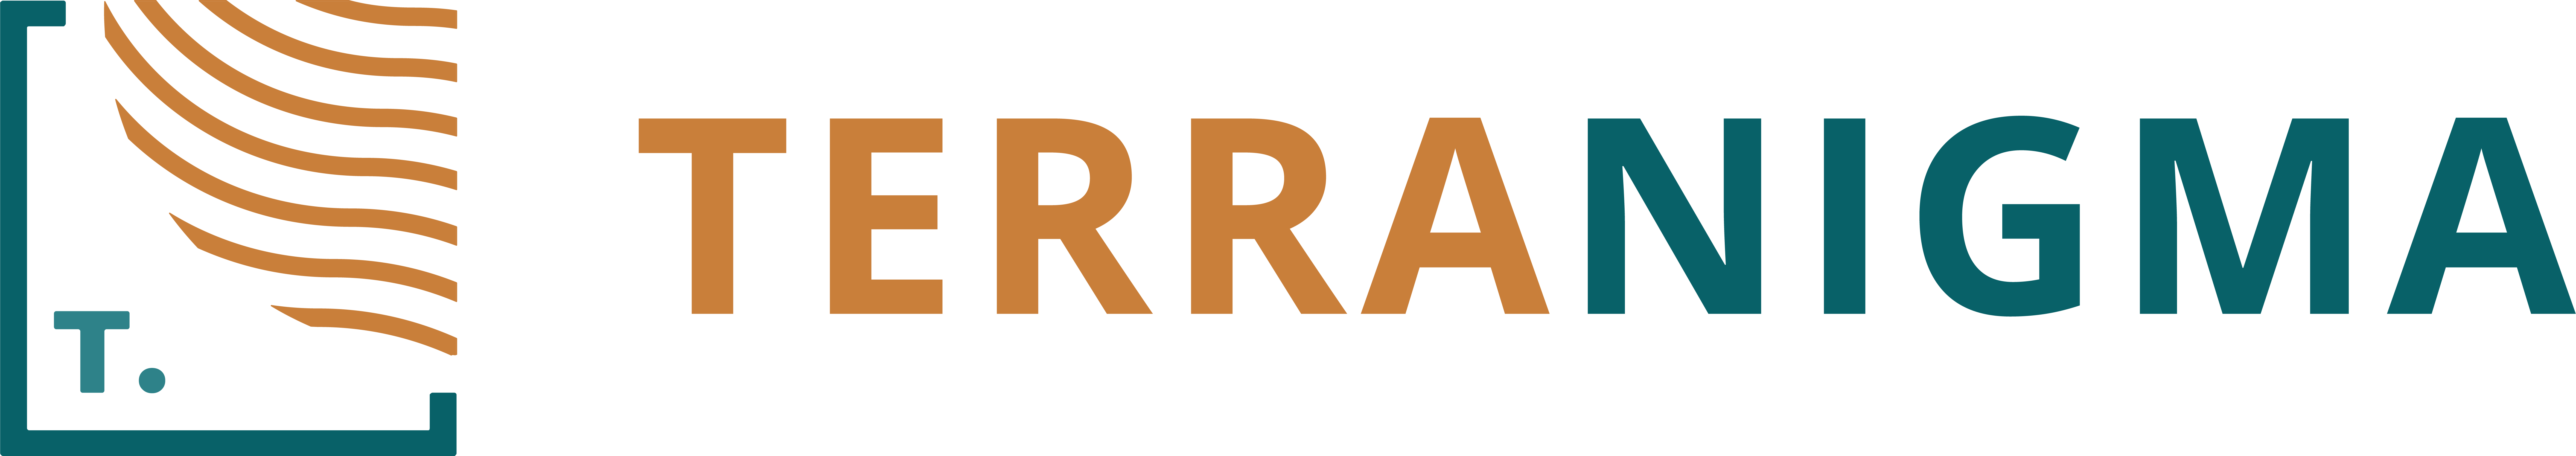

